In [2]:
from pathlib import Path
import os
import napari
import numpy as np
import tifffile
import pandas as pd
from skimage.transform import resize
from scipy.ndimage import binary_fill_holes
from utils import get_gpu_details, list_images, read_image

get_gpu_details()

Device name: /device:GPU:0
Device type: GPU
GPU model: device: 0, name: NVIDIA GeForce RTX 4090 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
# Copy the path where your images are stored, you can use absolute or relative paths to point at other disk locations
directory_path = Path("./raw_data/nihanseb_organoid")

# Image size reduction (downsampling) to improve processing times (slicing, not lossless compression)
# Now, in addition to xy, you can downsample across your z-stack
slicing_factor_xy = 4 # Use 2 or 4 for downsampling in xy (None for lossless)
slicing_factor_z = None # Use 2 to select 1 out of every 2 z-slices

# Define the nuclei and markers of interest channel order ('Remember in Python one starts counting from zero')
nuclei_channel = 2

# Fill holes inside the resulting organoid mask? Set to False if you want to keep the holes
fill_holes = True

# Analyze intensity within the 3D volume of the ROI, or perform a mean or max intensity projection of the marker channel (2D)
analysis_type = "2D" #"2D" or "3D"

# If 2D analysis type, Choose projection type (mean intensity or max intensity)
# Mean intensity projection would be the equivalent of analyzing avg_intensity within the 3D volume
projection_type = "mean" # "mean" or "max"

# Stardist model name if nuclei labels predictions are present
model_name = None

# Iterate through the .czi and .nd2 files in the raw_data directory
images = list_images(directory_path)

images

['raw_data\\nihanseb_organoid\\MLD 1.8 block4 ARSA MBP batch 1 40x.nd2',
 'raw_data\\nihanseb_organoid\\MLD 2.2 block7 MBP MAP2 slide 7 batch 2 40x.nd2']

In [4]:
# Explore each image to analyze (0 defines the first image in the directory)
image = images[0]

# Read image, apply slicing if needed and return filename and img as a np array
img, filename = read_image(image, slicing_factor_xy, slicing_factor_z)

# Generate maximum or mean intensity projection
if projection_type == "max":
    img_projection = np.max(img, axis=1)
elif projection_type == "mean":
    img_projection = np.mean(img, axis=1)

# Show image in Napari
viewer = napari.Viewer(ndisplay=2)
viewer.add_image(img_projection, name=f"{projection_type}_projection")

# Add the 3D-stack into Napari
if analysis_type == "3D":
    # Remove the projection layer if it exists
    if f"{projection_type}_projection" in viewer.layers:
        viewer.layers.remove(f"{projection_type}_projection")
    # Add the 'img' stack
    viewer.add_image(img)
    # Set projection_type variable to None
    projection_type = None



Image analyzed: MLD 1.8 block4 ARSA MBP batch 1 40x
Original Array shape: (3, 24, 10797, 10797)
Compressed Array shape: (3, 24, 2700, 2700)


In [5]:
# Define the channels you want to analyze using the following structure:
# markers = [(channel_name, channel_nr, min_max_range),(..., ...)]
# Remember in Python one starts counting from 0, so your first channel will be 0
# min_max range defines the pixel intensity range within which a cell is considered positive for a marker
# i.e. markers = [("ARSA", 0, (0, 65536)), ("MBP", 1, (0, 65536))]
markers = [("ARSA", 0, (110, 1000)), ("MBP", 1, (105, 200))]

In [13]:
# Construct ROI and nuclei predictions paths from directory_path above
roi_path = directory_path / "ROIs"
# nuclei_preds_path =  directory_path / "nuclei_preds" / analysis_type / model_name

# Extract the experiment name from the data directory path
experiment_id = directory_path.name

# Check for presence of ROIs
try:
    roi_names = [folder.name for folder in roi_path.iterdir() if folder.is_dir()]

except FileNotFoundError:
    roi_names = ["auto_generated_ROI"]
    print("No manually defined ROI found, generating ROI automatically...")

# Create a 'results' folder in the root directory to store results
results_folder = Path("results") / experiment_id / "perc_pos"

try:
    os.makedirs(results_folder)
    print(f"'{results_folder}' folder created successfully.")
except FileExistsError:
    print(f"'{results_folder}' folder already exists.")

# Initialize an empty list to hold the extracted dataframes on a per roi basis
props_list = []

# Initialize an empty list to store channel names and downsampled images on a per roi basis
plots = []

# Track added images
added_images = set()

for roi_name in roi_names:

    print(f"\nAnalyzing ROI: {roi_name}")

    # Initialize a dictionary to store data needed by matplotlib
    plot = {
            "filename": filename,
            "roi": roi_name,
            }

    # Read the user defined ROIs, in case of missing ROI implement logic for automatic segmentation
    try:
        # Read previously defined ROIs
        organoid_mask = tifffile.imread(roi_path / roi_name / f"{filename}.tiff")

    except FileNotFoundError:
        # Add logic to automatically generate an organoid mask
        pass

    # Resample the organoid ROI if input img and ROI shape differ
    if organoid_mask.shape[-2:] != img.shape[-2:]:
        roi_slicing_factor = organoid_mask.shape[-1] / img.shape[-1]
        
        if roi_slicing_factor > 1:
            print("Slicing ROI to match input image shape")
            roi_slicing_factor = round(organoid_mask.shape[-1] / img.shape[-1])
            organoid_mask = organoid_mask[::round(roi_slicing_factor), ::round(roi_slicing_factor)]
    
        elif roi_slicing_factor < 1:
            print("Upsampling ROI to match input image shape")
            organoid_mask = resize(
                organoid_mask, img.shape[-2:], order=0, preserve_range=True, anti_aliasing=False
            )

    # If analysis type == "3D" extend ROI over the entire volume
    if analysis_type == "3D":
        # Extract the number of z-slices to extend the mask
        slice_nr = img.shape[1]
        # Extend the mask across the entire volume
        organoid_mask = np.tile(organoid_mask, (slice_nr, 1, 1))
        
    # Show organoid ROI over input image 
    viewer.add_labels(organoid_mask)

    if fill_holes:
        # Close empty holes surrounded by True pixels
        organoid_mask = binary_fill_holes(organoid_mask)
        viewer.add_labels(organoid_mask, name="closed_organoids_mask")

    # Transform organoid mask into a label type without the need to perform connected components
    organoid_mask = organoid_mask.astype(np.uint8)

    # Create a dictionary containing all image descriptors
    descriptor_dict = {
                "filename": filename,
                "roi": roi_name,
                "fill_holes": fill_holes,
                "slicing_factor_xy": slicing_factor_xy,
                "analysis_type": analysis_type,
                "projection_type": projection_type,
                }
    
    # Update plot dict with ROI mask (#TODO: include 3D logic)
    plot["roi_mask"] = organoid_mask[::4, ::4]

    for channel_name, ch_nr, min_max_range in markers:

        print(f"Extracting % of ROI + for {channel_name} inside {analysis_type}_{roi_name}")

        if analysis_type == "2D":
            # Ignore pixel values below the min_range (set them to 0)
            img_projection[ch_nr] = np.where(img_projection[ch_nr] > min_max_range[0], img_projection[ch_nr], 0)

            # Only add image if it hasn't been added before
            if ch_nr not in added_images:
                viewer.add_image(img_projection[ch_nr], name=f"filtered_{channel_name}_input")
                added_images.add(ch_nr)  # Mark channel as added

            # Ignore pixels whose value is equal or above the max_range
            # ROI is modified to ignore said pixels (results in filtered organoid_mask)

            filtered_organoid_mask = np.where(img_projection[ch_nr] <= min_max_range[1], organoid_mask, 0)
            viewer.add_labels(filtered_organoid_mask, name=f"filtered_roi_for_{channel_name}")

            # Obtain ROI occupied by pixels positive for a marker within min_max_range
            roi_positive_for_marker = (img_projection[ch_nr] > 0) & (filtered_organoid_mask > 0)
            viewer.add_labels(roi_positive_for_marker, name=f"roi_+_for_{channel_name}") 
            
        elif analysis_type == "3D":
            # Ignore pixel values below the min_range (set them to 0)
            img[ch_nr] = np.where(img[ch_nr] > min_max_range[0], img[ch_nr], 0)

            # Only add image if it hasn't been added before
            if ch_nr not in added_images:
                viewer.add_image(img[ch_nr], name=f"filtered_{channel_name}_input")
                added_images.add(ch_nr)

            # Ignore pixels whose value is equal or above the max_range
            # ROI is modified to ignore said pixels (results in filtered organoid_mask)

            filtered_organoid_mask = np.where(img[ch_nr] <= min_max_range[1], organoid_mask, 0)
            viewer.add_labels(filtered_organoid_mask, name=f"filtered_roi_for_{channel_name}")

            # Obtain ROI occupied by pixels positive for a marker within min_max_range
            roi_positive_for_marker = (img[ch_nr]) > 0 & (filtered_organoid_mask > 0)
            viewer.add_labels(roi_positive_for_marker, name=f"roi_+_for_{channel_name}")

        # Update dictionary with data for matplotlib to plot (#TODO: Include 3D logic)
        plot[channel_name] = (img_projection[ch_nr, ::4, ::4], roi_positive_for_marker[::4, ::4])

        # Extract area information from filtered_organoid and roi_positive_for_marker
        # Compute the number of nonzero pixels
        total_filtered_area = np.count_nonzero(filtered_organoid_mask)
        total_positive_area = np.count_nonzero(roi_positive_for_marker)

        # Calculate the percentage
        percent_positive = (total_positive_area / total_filtered_area) * 100 if total_filtered_area > 0 else 0

        # Save extracted data in the descriptor_dictionary
        descriptor_dict[f"filtered_ROI_area_{channel_name}"] = total_filtered_area
        descriptor_dict[f"+_area_{channel_name}"] = total_positive_area
        descriptor_dict[f"+_area_{channel_name}"] = percent_positive

        print(f"Percentage of ROI occupied by {channel_name} marker: {percent_positive:.2f}%")
            
    # Convert to dataframe
    props_df = pd.DataFrame([descriptor_dict])

    # Add dataframe to ROI props list
    props_list.append(props_df)

    # Add updated plot dictionary to list 
    plots.append(plot)

    # Define the .csv path
    csv_path = results_folder / f'{filename}_perc_pos.csv'

    # Concatenate into a single DataFrame
    final_df = pd.concat(props_list, ignore_index=True) 

    # Save to .csv
    final_df.to_csv(csv_path)        

'results\nihanseb_organoid\perc_pos' folder already exists.

Analyzing ROI: organoid_1
Extracting % of ROI + for ARSA inside 2D_organoid_1
Percentage of ROI occupied by ARSA marker: 28.97%
Extracting % of ROI + for MBP inside 2D_organoid_1
Percentage of ROI occupied by MBP marker: 79.13%

Analyzing ROI: organoid_2
Extracting % of ROI + for ARSA inside 2D_organoid_2
Percentage of ROI occupied by ARSA marker: 34.94%
Extracting % of ROI + for MBP inside 2D_organoid_2
Percentage of ROI occupied by MBP marker: 82.51%


In [7]:
final_df

,filename,roi,fill_holes,slicing_factor_xy,analysis_type,projection_type,filtered_ROI_area_ARSA,+_area_ARSA,filtered_ROI_area_MBP,+_area_MBP
0,MLD 1.8 block4 ARSA MBP batch 1 40x,organoid_1,True,4,2D,mean,2319925,28.969212,2319929,79.128758
1,MLD 1.8 block4 ARSA MBP batch 1 40x,organoid_2,True,4,2D,mean,2182158,34.944399,2182309,82.512147


In [20]:
subplots_nr = (len(plot) - 3) * 2

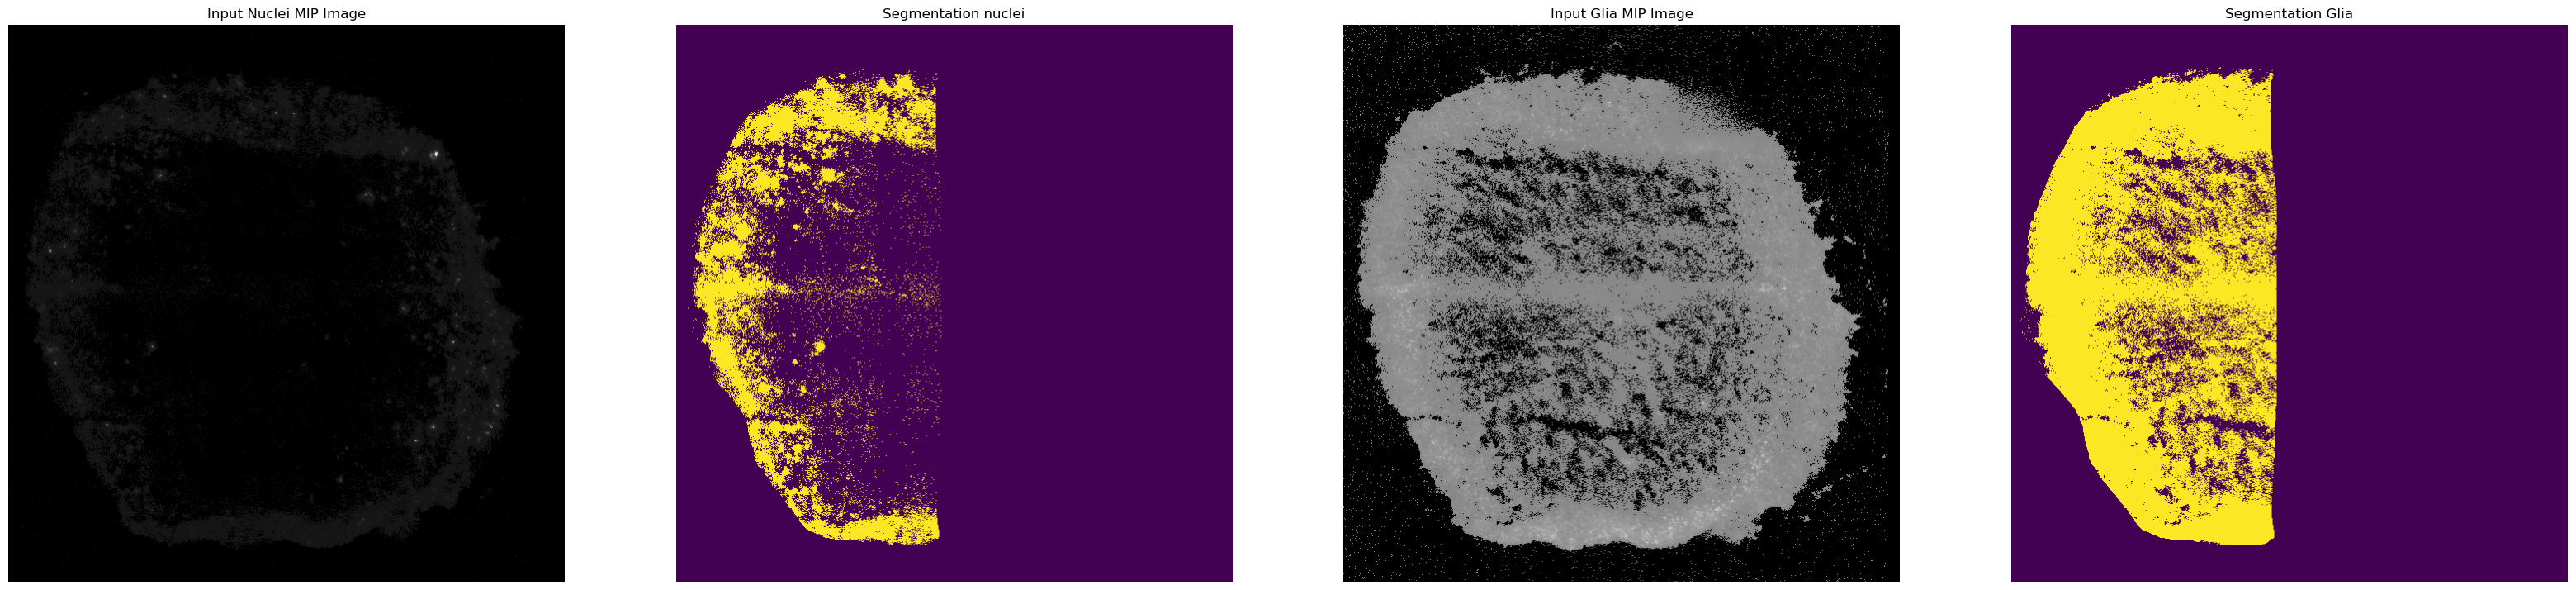

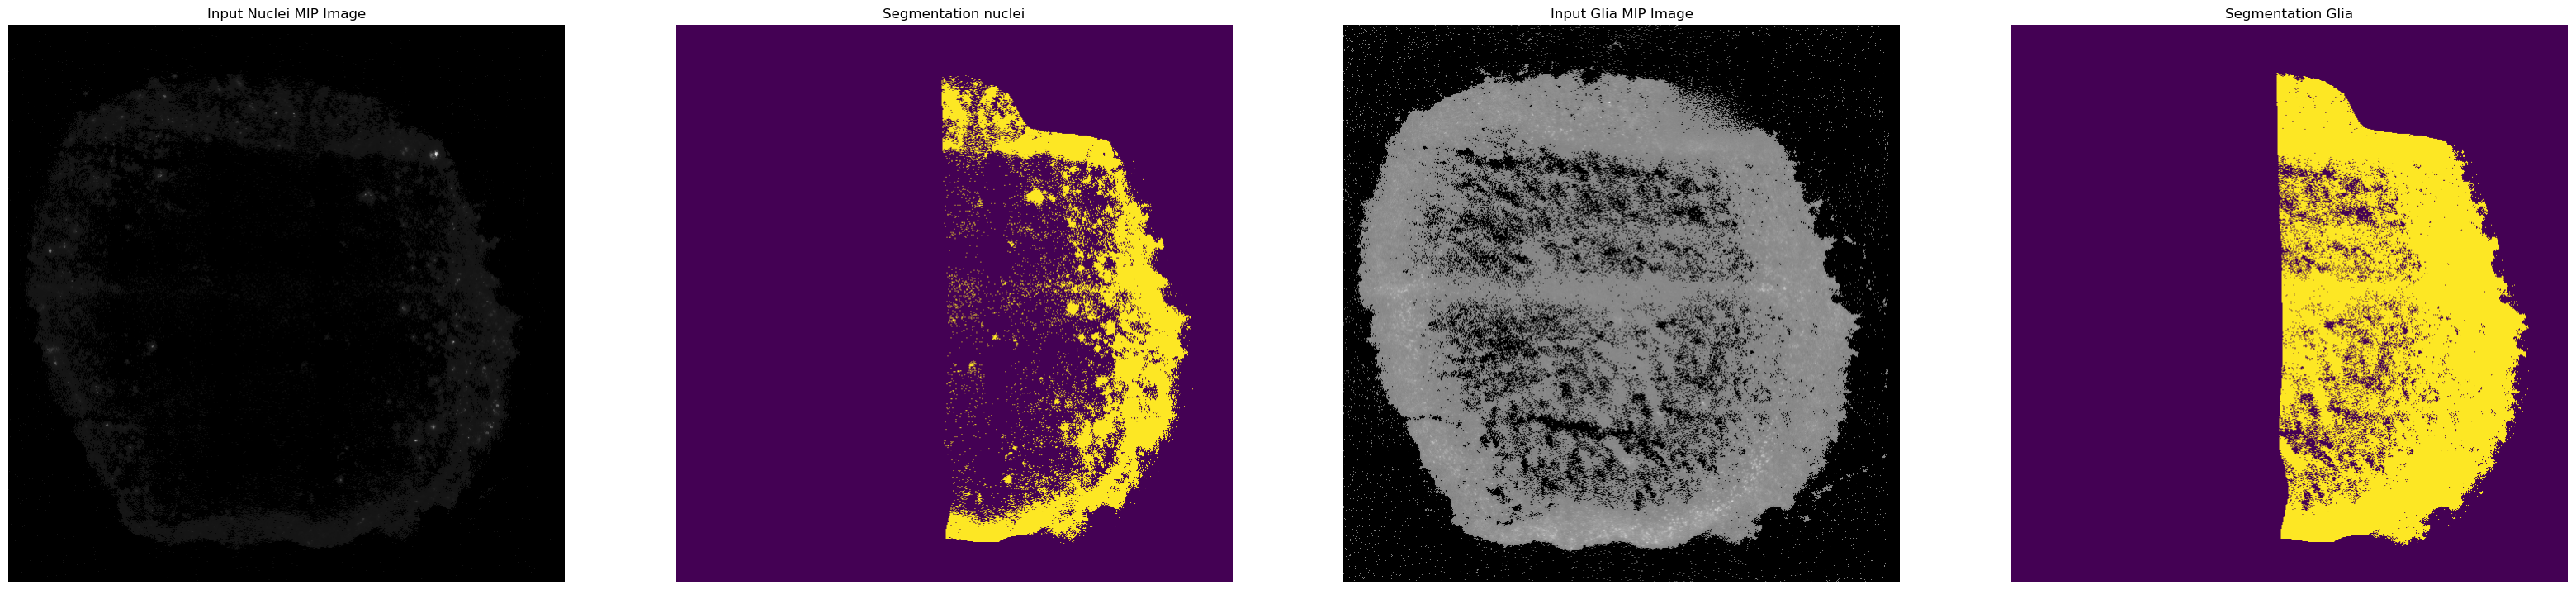

In [22]:
import matplotlib.pyplot as plt

for plot in plots:

    plt.figure(figsize=(40, 40))
    plt.subplot(1, subplots_nr, 1)
    plt.imshow(plot["ARSA"][0], cmap='gray')
    plt.title('Input Nuclei MIP Image')
    plt.axis("off")

    plt.subplot(1, subplots_nr, 2)
    plt.imshow(plot["ARSA"][1], cmap='viridis')
    plt.title('Segmentation nuclei')
    plt.axis("off")

    plt.subplot(1, subplots_nr, 3)
    plt.imshow(plot["MBP"][0], cmap='gray')
    plt.title('Input Glia MIP Image')
    plt.axis("off")

    plt.subplot(1, subplots_nr, 4)
    plt.imshow(plot["MBP"][1], cmap='viridis')
    plt.title('Segmentation Glia')
    plt.axis("off")